# Loading & Preprocessing

In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

Using TensorFlow backend.


In [2]:
# get all image in train folder  
# import glob

# files = glob.glob('breast/malignant/' + '/**/*.png', recursive=True)
# print(len(files))
# import os  
# import shutil
#Source path  
  
# Destination path  
# destination = 'data/train/malignant/'
  
# Move the content of  
# source to destination 
# using shutil.copytree() as parameter
# for n in files:
#     dest = shutil.move(n, destination, copy_function = shutil.copytree)  
#_________________Don't use Again______________________________________

In [3]:
# adding files in test and validation files
# import shutil, random, os
# dirpath = 'D:/Minor Project/data/train/malignant/'
# destDirectory = 'D:/Minor Project/Data2/validation/malignant/'

# filenames = random.sample(os.listdir(dirpath), 200)
# for fname in filenames:
#     srcpath = os.path.join(dirpath, fname)
#     shutil.move(srcpath, destDirectory)
# #__________________DON'T USE AGAIN_______________________________

In [24]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('data/train/benign',128))
malign_train = np.array(Dataset_loader('data/train/malignant',128))
benign_test = np.array(Dataset_loader('data/validation/benign',128))
malign_test = np.array(Dataset_loader('data/validation/malignant',128))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 67.23it/s]


# Create Label

In [25]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split

In [26]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Data Generator

In [28]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Model: ResNet50

In [29]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [30]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1920)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


In [31]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [32]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/20
80/79 [==============================] - ETA: 31:12 - loss: 0.6343 - accuracy: 0.625 - ETA: 15:38 - loss: 0.7644 - accuracy: 0.562 - ETA: 10:26 - loss: 0.8308 - accuracy: 0.541 - ETA: 7:50 - loss: 0.7938 - accuracy: 0.593 - ETA: 6:16 - loss: 0.8182 - accuracy: 0.56 - ETA: 5:14 - loss: 0.7974 - accuracy: 0.57 - ETA: 4:29 - loss: 0.7684 - accuracy: 0.58 - ETA: 3:55 - loss: 0.7838 - accuracy: 0.57 - ETA: 3:29 - loss: 0.7882 - accuracy: 0.56 - ETA: 3:08 - loss: 0.7694 - accuracy: 0.56 - ETA: 2:50 - loss: 0.7833 - accuracy: 0.55 - ETA: 2:36 - loss: 0.7894 - accuracy: 0.55 - ETA: 2:24 - loss: 0.7803 - accuracy: 0.55 - ETA: 2:13 - loss: 0.7916 - accuracy: 0.55 - ETA: 2:04 - loss: 0.7920 - accuracy: 0.55 - ETA: 1:56 - loss: 0.7852 - accuracy: 0.56 - ETA: 1:48 - loss: 0.7825 - accuracy: 0.56 - ETA: 1:42 - loss: 0.7716 - accuracy: 0.57 - ETA: 1:36 - loss: 0.7668 - accuracy: 0.57 - ETA: 1:31 - loss: 0.7836 - accuracy: 0.56 - ETA: 1:26 - loss: 0.7841 - accuracy: 0.57 - ETA: 1:22 - loss:

C:\Users\MAYANK\AppData\Local\Continuum\anaconda3\envs\MyGPU\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Users\MAYANK\AppData\Local\Continuum\anaconda3\envs\MyGPU\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/20
80/79 [==============================] - ETA: 28s - loss: 0.7483 - accuracy: 0.687 - ETA: 28s - loss: 0.7091 - accuracy: 0.656 - ETA: 27s - loss: 0.7486 - accuracy: 0.604 - ETA: 27s - loss: 0.6370 - accuracy: 0.656 - ETA: 27s - loss: 0.6304 - accuracy: 0.675 - ETA: 27s - loss: 0.5879 - accuracy: 0.708 - ETA: 26s - loss: 0.6284 - accuracy: 0.687 - ETA: 26s - loss: 0.6263 - accuracy: 0.679 - ETA: 25s - loss: 0.6294 - accuracy: 0.687 - ETA: 25s - loss: 0.5930 - accuracy: 0.700 - ETA: 25s - loss: 0.5916 - accuracy: 0.704 - ETA: 25s - loss: 0.5836 - accuracy: 0.713 - ETA: 24s - loss: 0.6044 - accuracy: 0.706 - ETA: 24s - loss: 0.5872 - accuracy: 0.718 - ETA: 23s - loss: 0.5814 - accuracy: 0.720 - ETA: 23s - loss: 0.5625 - accuracy: 0.734 - ETA: 23s - loss: 0.5445 - accuracy: 0.746 - ETA: 22s - loss: 0.5404 - accuracy: 0.756 - ETA: 22s - loss: 0.5581 - accuracy: 0.750 - ETA: 21s - loss: 0.5547 - accuracy: 0.756 - ETA: 21s - loss: 0.5644 - accuracy: 0.756 - ETA: 21s - loss: 0.5511 

80/79 [==============================] - ETA: 27s - loss: 0.3007 - accuracy: 0.875 - ETA: 27s - loss: 0.4030 - accuracy: 0.781 - ETA: 27s - loss: 0.3247 - accuracy: 0.833 - ETA: 27s - loss: 0.4202 - accuracy: 0.781 - ETA: 26s - loss: 0.4161 - accuracy: 0.775 - ETA: 26s - loss: 0.4370 - accuracy: 0.770 - ETA: 26s - loss: 0.4624 - accuracy: 0.767 - ETA: 25s - loss: 0.4592 - accuracy: 0.773 - ETA: 25s - loss: 0.4704 - accuracy: 0.777 - ETA: 25s - loss: 0.4511 - accuracy: 0.787 - ETA: 24s - loss: 0.4439 - accuracy: 0.795 - ETA: 24s - loss: 0.4365 - accuracy: 0.807 - ETA: 24s - loss: 0.4635 - accuracy: 0.798 - ETA: 24s - loss: 0.4481 - accuracy: 0.803 - ETA: 23s - loss: 0.4467 - accuracy: 0.804 - ETA: 23s - loss: 0.4524 - accuracy: 0.796 - ETA: 22s - loss: 0.4388 - accuracy: 0.801 - ETA: 22s - loss: 0.4654 - accuracy: 0.798 - ETA: 22s - loss: 0.4608 - accuracy: 0.799 - ETA: 21s - loss: 0.4525 - accuracy: 0.803 - ETA: 21s - loss: 0.4463 - accuracy: 0.803 - ETA: 21s - loss: 0.4407 - accuracy:

80/79 [==============================] - ETA: 29s - loss: 0.2720 - accuracy: 0.875 - ETA: 28s - loss: 0.5177 - accuracy: 0.750 - ETA: 28s - loss: 0.4791 - accuracy: 0.770 - ETA: 27s - loss: 0.4359 - accuracy: 0.781 - ETA: 27s - loss: 0.4257 - accuracy: 0.800 - ETA: 27s - loss: 0.3960 - accuracy: 0.822 - ETA: 26s - loss: 0.3509 - accuracy: 0.848 - ETA: 26s - loss: 0.3216 - accuracy: 0.867 - ETA: 25s - loss: 0.3202 - accuracy: 0.861 - ETA: 25s - loss: 0.2986 - accuracy: 0.875 - ETA: 25s - loss: 0.3025 - accuracy: 0.863 - ETA: 25s - loss: 0.3454 - accuracy: 0.849 - ETA: 24s - loss: 0.3320 - accuracy: 0.855 - ETA: 24s - loss: 0.3522 - accuracy: 0.852 - ETA: 23s - loss: 0.3511 - accuracy: 0.850 - ETA: 23s - loss: 0.3521 - accuracy: 0.847 - ETA: 23s - loss: 0.3412 - accuracy: 0.852 - ETA: 22s - loss: 0.3610 - accuracy: 0.843 - ETA: 22s - loss: 0.3681 - accuracy: 0.838 - ETA: 22s - loss: 0.3788 - accuracy: 0.840 - ETA: 21s - loss: 0.3734 - accuracy: 0.842 - ETA: 21s - loss: 0.3708 - accuracy:

80/79 [==============================] - ETA: 28s - loss: 0.1175 - accuracy: 0.937 - ETA: 28s - loss: 0.2822 - accuracy: 0.843 - ETA: 27s - loss: 0.2562 - accuracy: 0.854 - ETA: 27s - loss: 0.2877 - accuracy: 0.843 - ETA: 27s - loss: 0.2649 - accuracy: 0.862 - ETA: 26s - loss: 0.2372 - accuracy: 0.885 - ETA: 26s - loss: 0.2588 - accuracy: 0.866 - ETA: 26s - loss: 0.2750 - accuracy: 0.867 - ETA: 25s - loss: 0.2747 - accuracy: 0.868 - ETA: 25s - loss: 0.2783 - accuracy: 0.868 - ETA: 25s - loss: 0.2673 - accuracy: 0.869 - ETA: 24s - loss: 0.2645 - accuracy: 0.875 - ETA: 24s - loss: 0.2694 - accuracy: 0.870 - ETA: 23s - loss: 0.2724 - accuracy: 0.866 - ETA: 23s - loss: 0.2643 - accuracy: 0.870 - ETA: 23s - loss: 0.2553 - accuracy: 0.875 - ETA: 22s - loss: 0.2567 - accuracy: 0.875 - ETA: 22s - loss: 0.2557 - accuracy: 0.875 - ETA: 22s - loss: 0.2676 - accuracy: 0.875 - ETA: 21s - loss: 0.2715 - accuracy: 0.878 - ETA: 21s - loss: 0.2628 - accuracy: 0.883 - ETA: 20s - loss: 0.2554 - accuracy:

80/79 [==============================] - ETA: 28s - loss: 0.2833 - accuracy: 0.875 - ETA: 28s - loss: 0.2631 - accuracy: 0.906 - ETA: 28s - loss: 0.2776 - accuracy: 0.854 - ETA: 27s - loss: 0.2579 - accuracy: 0.875 - ETA: 27s - loss: 0.2353 - accuracy: 0.887 - ETA: 27s - loss: 0.2054 - accuracy: 0.906 - ETA: 26s - loss: 0.1849 - accuracy: 0.919 - ETA: 26s - loss: 0.2658 - accuracy: 0.890 - ETA: 26s - loss: 0.2674 - accuracy: 0.888 - ETA: 25s - loss: 0.2492 - accuracy: 0.893 - ETA: 25s - loss: 0.2388 - accuracy: 0.897 - ETA: 25s - loss: 0.2558 - accuracy: 0.885 - ETA: 24s - loss: 0.2499 - accuracy: 0.884 - ETA: 24s - loss: 0.3122 - accuracy: 0.870 - ETA: 24s - loss: 0.2989 - accuracy: 0.879 - ETA: 23s - loss: 0.2960 - accuracy: 0.875 - ETA: 23s - loss: 0.2836 - accuracy: 0.882 - ETA: 23s - loss: 0.2804 - accuracy: 0.881 - ETA: 22s - loss: 0.2999 - accuracy: 0.875 - ETA: 22s - loss: 0.2914 - accuracy: 0.878 - ETA: 21s - loss: 0.2822 - accuracy: 0.881 - ETA: 21s - loss: 0.2745 - accuracy:

In [33]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

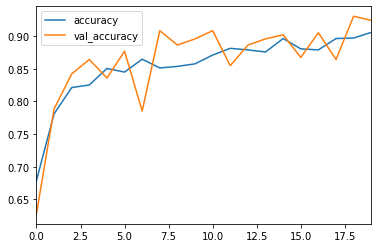

In [35]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()
# history_df

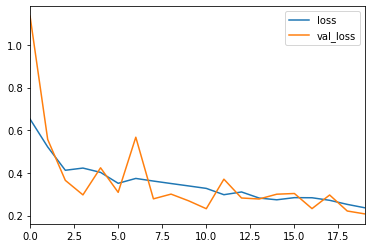

In [36]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [38]:
# model.save("weights.best.hdf5")
model.load_weights("weights.best.hdf5")

In [39]:
Y_val_pred = model.predict(x_val)

In [40]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9242902208201893